In [1]:
import time
import dask
import numpy as np
import xarray as xr
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from collections import OrderedDict
from keras.callbacks import LearningRateScheduler
from lossycomp.dataLoader import DataGenerator, data_preprocessing, split_data, norm_data
from lossycomp.utils import check_gpu, decay_schedule, correlation, gaussian_kernel, lr_log_reduction
from lossycomp.plots import mult_plot, single_plot, plot_history
from lossycomp.models import Autoencoder

In [2]:
(encoder, decoder, model) = Autoencoder.build(16, 48, 48, 1, filters = (10, 20, 20, 20))

In [3]:
model.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 48, 48, 1)]   0         
_________________________________________________________________
Encoder (Functional)         (None, 1, 3, 3, 20)       64710     
_________________________________________________________________
Decoder (Functional)         (None, 16, 48, 48, 1)     64691     
Total params: 129,401
Trainable params: 129,401
Non-trainable params: 0
_________________________________________________________________


In [4]:
def mean_squared_error(y_true, y_pred):
    y_shape = y_pred.shape
    ker = gaussian_kernel(d=y_shape[1] , l=y_shape[2], sig =3.)
    y_pred = y_pred[:,:,:,:,0] * ker
    y_true = y_true[:,:,:,:,0] * ker
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [5]:
learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 100
epomin = 30
epostep = 1

cbk1 = tf.keras.callbacks.LearningRateScheduler(lr_log_reduction(learning_rate_start, learning_rate_stop, epomin = epomin, epo = epo))

In [6]:
#model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss= mean_squared_error, metrics=[ mean_squared_error])
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss= tf.keras.losses.MeanSquaredError(), metrics=[ tf.keras.losses.MeanSquaredError()])

from lossycomp.constants import Region, REGIONS
def preprocessing(path, var, region):
    """ Returns preprocessed data, mean and std.
    Arguments
    =========
    path: Path to the netcdf file.
    var: Dictionary of the form {'var': level}. Use None for level if data is of single level.
    region: Region to be cropped. Boundary region over lat,lon. 
    Predefined regions set in `constants` module.
    """

    assert isinstance(region, (str, Region))
    if isinstance(region, str) and region not in REGIONS.keys():
        raise KeyError("Region unknown!")
    else:
        region = REGIONS[region] 
    
    z = path
       
    data = z.sel(longitude=slice(region.min_lon,region.max_lon),
                 latitude=slice(region.min_lat,region.max_lat), level = 1000)
    

    mean = data['t'].mean(('time', 'latitude', 'longitude')).compute() 
    std = data['t'].std('time').mean(('latitude', 'longitude')).compute()
    
    return data

def split_data(data, percentage):
    """ Returns splitted train-test data depending
    on specified dimension.
    Arguments
    =========
    data: Dataarray.
    percentage: % of data in train data in decimal (70% = 0.7).
    """
    idx = np.arange(len(data.time))
    np.random.shuffle(idx)
    train_idx =idx[0: int(len(idx)*percentage)]
    test_idx = idx[len(train_idx):len(idx)]

    data_train = data.isel(time=np.sort(train_idx))
    data_test = data.isel(time=np.sort(test_idx))

    return (data_train, data_test)

class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, num_samples, leads, mean, std, batch_size=10, standardize = False, coords = False, soil = False, load=True):
        """
        Data generator. The samples generated are shuffled.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            data: DataArray
            leads: Determines chunk size on each dimension. 
                   Format dict(time=12, longitude=10, latitude=10, level=1)
            num_samples: Int. Number of random lead chunks.
            batch_size: Int. Batch size.
            load: bool. If True, datadet is loaded into RAM.
            mean: Mean from dataset.
            coords: Include coordinates information.
            std: Standart deviation from dataset.
        """
        self.data = data
        self.num_samples = num_samples
        self.mean = mean
        self.std = std
        self.batch_size = batch_size
        self.leads = leads
        self.coords = coords
        self.soil = soil
        self.check_inputs()
        
        if standardize:
            self.data = (self.data - self.mean) / self.std

        tim_diff, lat_diff, lon_diff, lev_diff, subset_shape = self.check_chunks()
        
        subset = self.data.isel(
            time = slice(None, tim_diff),
            level = slice(None, lev_diff),
            latitude = slice(None, lat_diff),
            longitude = slice(None, lon_diff),
        )
        
        
        self.subset_shape = subset_shape[0], subset_shape[1], subset_shape[2], subset_shape[3]
                
        self.subset_length = int(np.prod(self.subset_shape))
        
        self.on_epoch_end()

        if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(self.num_samples/self.batch_size)

    def calculateValues(self, ix):
        tix, levix, latix, lonix = np.unravel_index(ix, self.subset_shape)
        subset_selection = dict(
            longitude = slice(lonix, lonix + self.leads["longitude"]),
            latitude = slice(latix, latix + self.leads["latitude"]),
            level = slice(levix, levix + self.leads["level"]),
            time = slice(tix, tix + self.leads["time"]),
        )

        whole = self.data.isel(**subset_selection)
        
        whole_data = self.data.isel(**subset_selection)
        
        # Add coordinates as extra channels.
        if self.coords:
            lat = whole.coords['latitude'].values
            lon = whole.coords['longitude'].values
            lat_st = np.stack([encode_lat(x) for x in lat])
            lon_st = np.stack([encode_lon(x) for x in lon])
            lat1, lat2 = np.hsplit(lat_st, 2)
            lon1, lon2 = np.hsplit(lon_st, 2)
            xx, yy = np.meshgrid(lon1, lat1)
            xx2, yy2 = np.meshgrid(lon2, lat2)
            
            #xx, yy = np.meshgrid(lon, lat)
            
            coords_lat = np.concatenate([[xx]] * len(whole.time), axis=0)
            coords_lon = np.concatenate([[yy]] * len(whole.time), axis=0)
            coords_lat1 = np.concatenate([[xx2]] * len(whole.time), axis=0)
            coords_lon1 = np.concatenate([[yy2]] * len(whole.time), axis=0)
            coords_lat = np.expand_dims(coords_lat, axis=3)
            coords_lon = np.expand_dims(coords_lon, axis=3)
            coords_lat1 = np.expand_dims(coords_lat1, axis=3)
            coords_lon1 = np.expand_dims(coords_lon1, axis=3)
            whole_data =  np.concatenate((whole_data, coords_lat, coords_lon, coords_lat1, coords_lon1 ),axis = 3)
            
        if type(self.soil) is not bool:
            soil_data = self.soil.isel(**subset_selection)
            whole_data = np.concatenate((whole_data, soil_data),axis = 3)
            
        return whole_data
    
    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size : (i + 1) * self.batch_size]
        x = np.stack([self.calculateValues(i).data for i in idxs], axis = 0)
        if x == np.float64:
            x= np.array(x, dtype = np.float32)
        return x, x
    
    def info_extra(self, ix):
        tix, levix, latix, lonix = np.unravel_index(ix, self.subset_shape)
        subset_selection = dict(
            longitude = slice(lonix, lonix + self.leads["longitude"]),
            latitude = slice(latix, latix + self.leads["latitude"]),
            level = slice(levix, levix + self.leads["level"]),
            time = slice(tix, tix + self.leads["time"]),
        )
        return subset_selection
    
    def info(self, i):
        idxs = self.idxs[i * self.batch_size : (i + 1) * self.batch_size]
        info = np.stack([self.info_extra(i) for i in idxs], axis = 0)
        return info 
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        #random.seed(30)
        self.idxs = random.sample(range(0, self.subset_length), self.num_samples)
            
    def check_inputs(self):
        assert isinstance(self.data, xr.core.dataarray.DataArray)
        assert isinstance(self.leads, dict)
        assert all(var in self.leads for var in ['longitude', 'time', 'latitude', 'level'])
        
    def check_chunks(self):
        tim_diff = self.data.time.size - self.leads["time"]
        lat_diff = self.data.latitude.size - self.leads["latitude"] 
        lon_diff = self.data.longitude.size - self.leads["longitude"]
        lev_diff = self.data.level.size - self.leads["level"] 
        if (tim_diff < 0 or lat_diff < 0 or lon_diff < 0 or lev_diff < 0):
            raise ValueError("Chunk size can't be bigger than data size.")
            
        subset_shape = [tim_diff, lev_diff, lat_diff, lon_diff]
        
        if tim_diff == 0:
            tim_diff = len(self.data.time)
            subset_shape[0] = 1
        if lat_diff == 0:
            lat_diff = len(self.data.latitude)
            subset_shape[2] = 1
        if lon_diff == 0:
            lon_diff = len(self.data.longitude)
            subset_shape[3] = 1
        if lev_diff == 0:
            lev_diff = len(self.data.level)
            subset_shape[1] = 1
        return tim_diff, lat_diff, lon_diff, lev_diff, subset_shape

In [7]:
ds = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc', combine='by_coords')
data_or = ds.sel(level = slice(978,1000))

ds = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1979/*/ERA5.sl.land_sea_mask.nc', combine='by_coords')

soil_d =[]
generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
soil_d.append(ds['lsm'].expand_dims({'level': generic_level}, 1))
soil_d = xr.concat(soil_d, 'level').transpose('time', 'latitude', 'longitude', 'level')
data_or["lsm"]=(['time', 'latitude', 'longitude', 'level'], soil_d)

In [8]:
data_or

<xarray.Dataset>
Dimensions:    (latitude: 721, level: 1, longitude: 1440, time: 8760)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 1000
  * time       (time) datetime64[ns] 1979-01-01 ... 1979-12-31T23:00:00
Data variables:
    t          (time, level, latitude, longitude) float32 dask.array<chunksize=(744, 1, 721, 1440), meta=np.ndarray>
    lsm        (time, latitude, longitude, level) float32 0.0 0.0 ... 1.0 1.0
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-26 16:14:37 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [9]:
dask.config.set(**{'array.slicing.split_large_chunks': False})

file = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc'
maps = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.sl.land_sea_mask.nc'
region = "europe"
var = OrderedDict({'t': 1000})

z,mean,std= data_preprocessing(file, var, region)


#######

from lossycomp.constants import Region, REGIONS

region = REGIONS[region]

soil = xr.open_mfdataset(maps, combine='by_coords')
soil = soil.sel(longitude=slice(region.min_lon,region.max_lon),
                 latitude=slice(region.min_lat,region.max_lat))
ds = []
generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
ds.append(soil['lsm'].expand_dims({'level': generic_level}, 1))
soil_d = xr.concat(ds, 'level').transpose('time', 'latitude', 'longitude', 'level')
z["lsm"]=(['time', 'latitude', 'longitude', 'level'], soil_d)

##########

train, test = split_data(z, 0.70)
leads = dict(time = 16, longitude=48, latitude=48, level=1)

In [10]:
train

<xarray.DataArray 't' (time: 6132, latitude: 161, longitude: 197, level: 1)>
dask.array<getitem, shape=(6132, 161, 197, 1), dtype=float32, chunksize=(535, 161, 197, 1), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -16.0 -15.75 -15.5 -15.25 ... 32.5 32.75 33.0
  * latitude   (latitude) float32 74.0 73.75 73.5 73.25 ... 34.5 34.25 34.0
  * level      (level) int64 1000
  * time       (time) datetime64[ns] 1979-01-01 ... 1979-12-31T23:00:00
    lsm        (time, latitude, longitude, level) float32 0.0 0.0 ... 0.0 0.0
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

In [18]:
dg_train = DataGenerator(train, 100, leads, batch_size=10, load=True, mean= mean, std=std, soil = True,  coords = False, standardize = True) 
#dg_test = DataGenerator(test, 300, leads, batch_size=10, load=True, mean= mean, std=std, coords = False, standardize = True)

Loading data into RAM


In [19]:
dg_train.__getitem__(1)[0][0][0][0]

array([[-0.13683838,  0.        ],
       [-0.15179382,  0.        ],
       [-0.17438975,  0.        ],
       [-0.1900111 ,  0.        ],
       [-0.19632474,  0.        ],
       [-0.19499296,  0.        ],
       [-0.18635608,  0.        ],
       [-0.17572154,  0.        ],
       [-0.17040427,  0.        ],
       [-0.1694079 ,  0.        ],
       [-0.17040427,  0.        ],
       [-0.17339338,  0.        ],
       [-0.17572154,  0.        ],
       [-0.17572154,  0.        ],
       [-0.17572154,  0.        ],
       [-0.17472517,  0.        ],
       [-0.17106523,  0.        ],
       [-0.16707975,  0.        ],
       [-0.16608337,  0.        ],
       [-0.16575289,  0.        ],
       [-0.16375521,  0.        ],
       [-0.16308932,  0.        ],
       [-0.16475159,  0.        ],
       [-0.165087  ,  0.        ],
       [-0.16541748,  0.        ],
       [-0.16707975,  0.        ],
       [-0.16741022,  0.        ],
       [-0.16275884,  0.        ],
       [-0.15810746,

In [36]:
#lr_scheduler = LearningRateScheduler(decay_schedule)

In [57]:
history = model.fit(dg_train, validation_data = dg_test, validation_freq=epostep, epochs=epo, callbacks= [cbk1] )#, workers = 4, use_multiprocessing = True)

Epoch 1/100
300/300 [==============================] - 3s 10ms/step - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0836 - val_mean_squared_error: 0.0836
Epoch 2/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0786 - val_mean_squared_error: 0.0786
Epoch 3/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0689 - val_mean_squared_error: 0.0689
Epoch 4/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0764 - val_mean_squared_error: 0.0764
Epoch 5/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0707 - val_mean_squared_error: 0.0707
Epoch 6/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0710 - val_mean_squared_error: 0.0710
Epoch 7/100
300/300 [

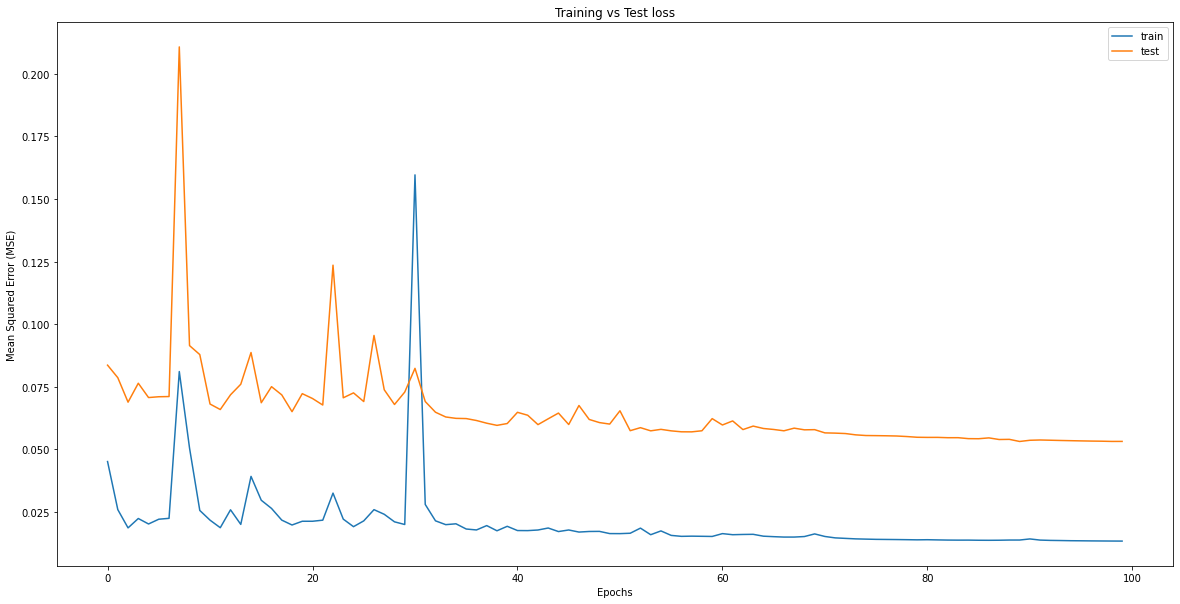

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
#model.save_weights('model_resAuto2/weights')

plt.plot(range(len(history.history["loss"])), history.history["loss"], label = "train")
plt.plot(range(len(history.history["loss"])), history.history["val_loss"], label = "test")
#plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training vs Test loss')
plt.legend()

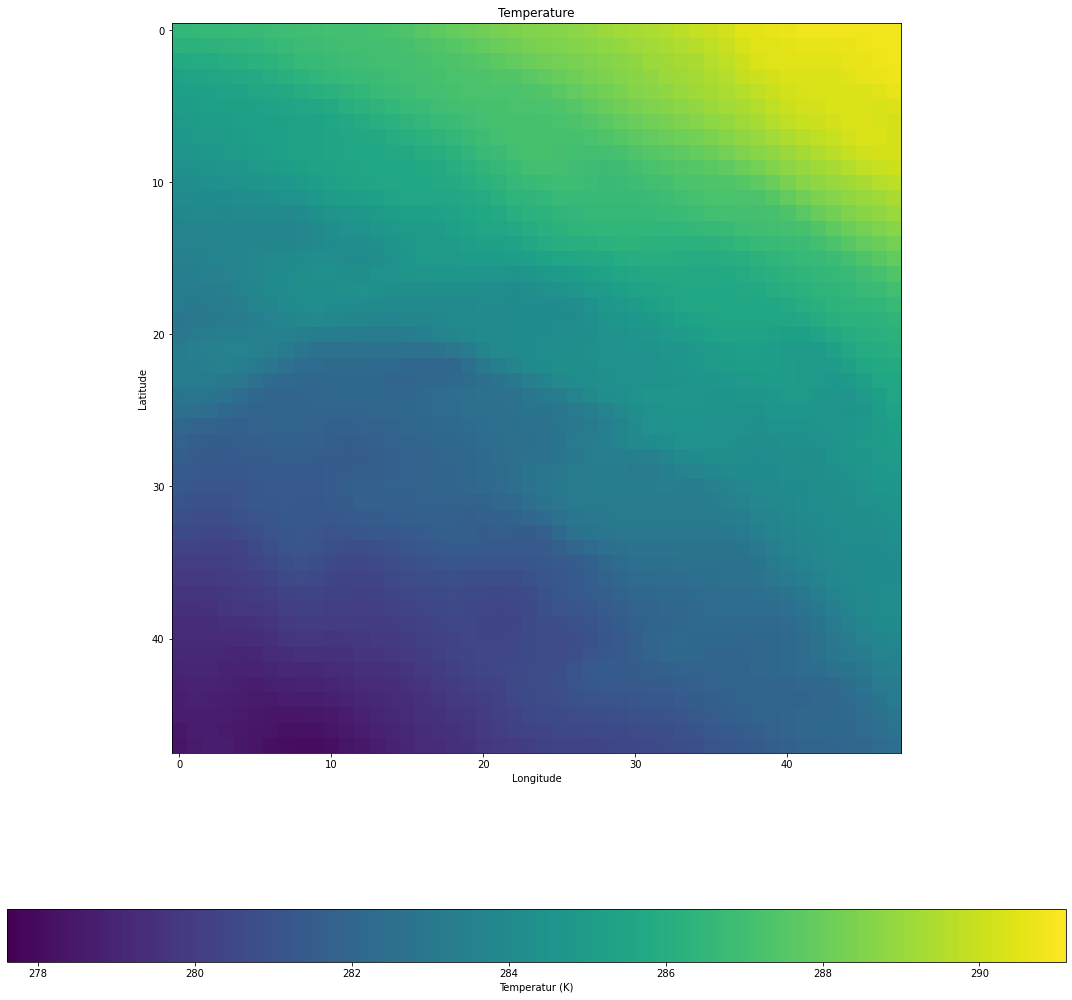

In [59]:
a = dg_train.__getitem__(9)[0] 
a_n = norm_data(a, mean, std)
single_plot(a_n, 5, "Temperature", "Temperatur (K)", a_n[0,:,:,:,0].min(), a_n[0,:,:,:,0].max())

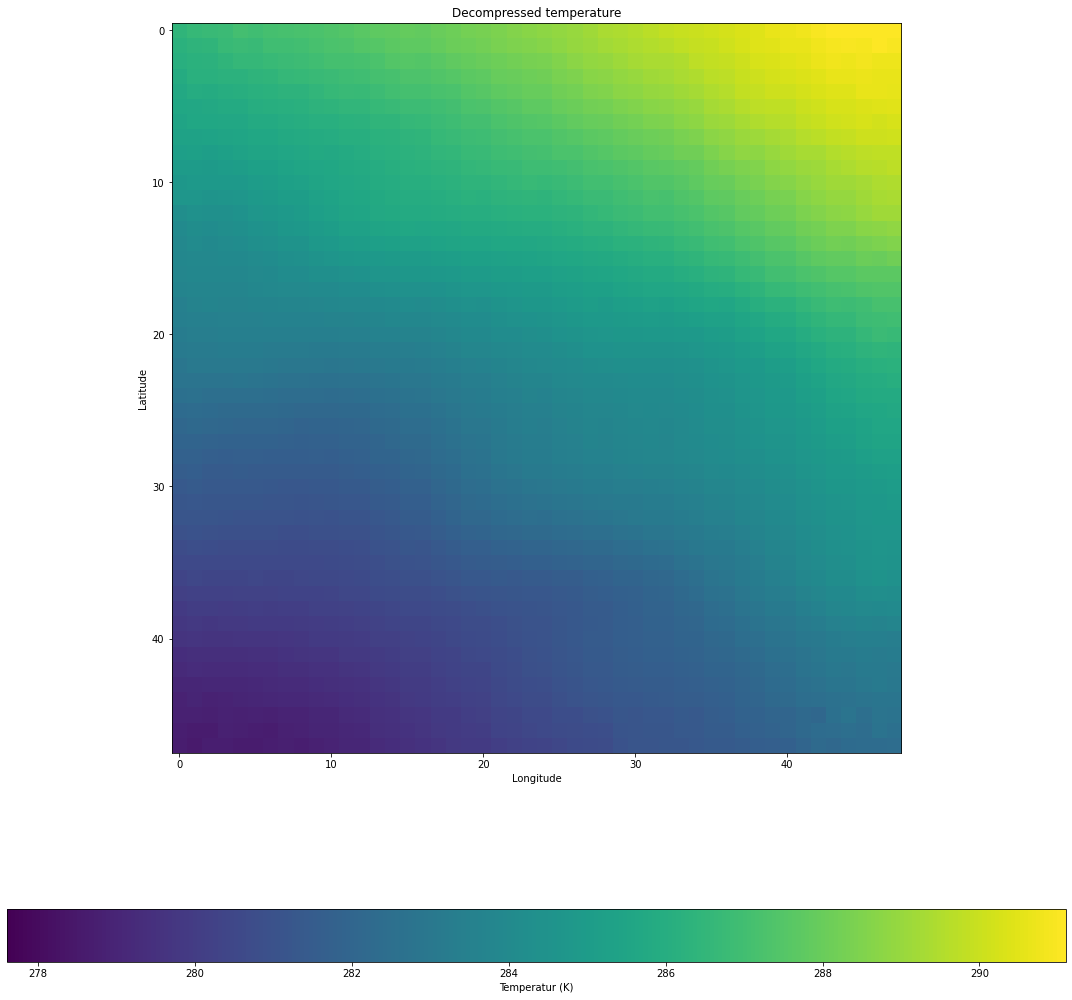

In [60]:
result = model(np.expand_dims(a[0], axis=0)).numpy()
result = norm_data(result, mean, std)
single_plot(result, 4, "Decompressed temperature" ,"Temperatur (K)", a_n[0,:,:,:,0].min(), a_n[0,:,:,:,0].max()) 

In [4]:
import pickle
import matplotlib.pyplot as plt

# Saving of plottings
with open('../results/model_200_300/model-history.pkl', 'rb') as f:
    data = pickle.load(f)

def get_values(data, mode):
    val1 = []
    val2 = []
    val3 = [] 
    for values in data['model'][mode]:
        val1.append(values['loss'])
        val2.append(values['correlation'])
        val3.append(values['MAE'])
    return val1, val2, val3


epochs = range(1, 1 + 17)

In [6]:
data['time']

'23:59:36.30'

'\nplt.figure(1)\nplt.plot(epochs, r2, label = "train")\nplt.plot(epochs, val_r2, label = "test")\nplt.xlabel(\'Epochs\')\nplt.ylabel(\'R2\')\nplt.title(\'Training vs Test R2\')\nplt.legend()\n\n\nplt.figure(2)\nplt.plot(epochs, mae, label = "train")\nplt.plot(epochs, val_mae, label = "test")\nplt.xlabel(\'Epochs\')\nplt.ylabel(\'Mean Absolute Error (MAE)\')\nplt.title(\'Training vs Test MAE\')\nplt.legend()\n\n\n'

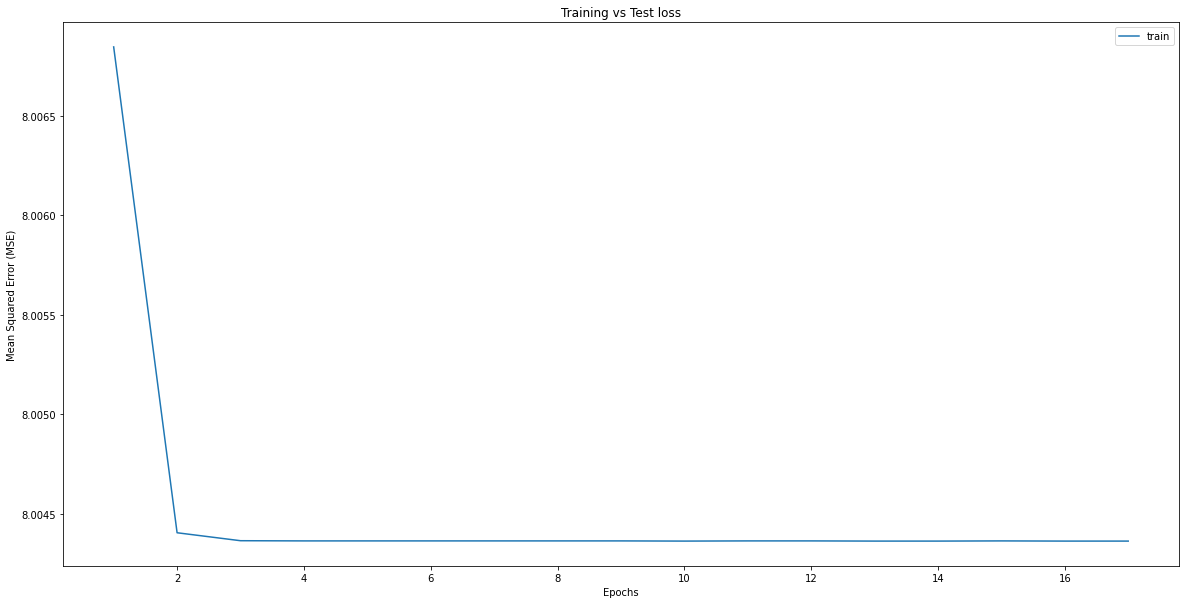

In [10]:
loss, r2, mae = get_values(data, 'train')
val_loss, val_r2, val_mae = get_values(data, 'test')


plt.figure(figsize=(20,10))
plt.plot(epochs, loss, label = "train")
#plt.plot(epochs, val_loss, label = "test")
#plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training vs Test loss')
plt.legend()

"""
plt.figure(1)
plt.plot(epochs, r2, label = "train")
plt.plot(epochs, val_r2, label = "test")
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.title('Training vs Test R2')
plt.legend()


plt.figure(2)
plt.plot(epochs, mae, label = "train")
plt.plot(epochs, val_mae, label = "test")
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training vs Test MAE')
plt.legend()


"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

patch_128 = pd.read_csv(
    '../results/models_patch_same_1/model_history_log.csv') #3k data

patch_48 = pd.read_csv(
    '../results/models_patch_same/model_history_log.csv') #9k data

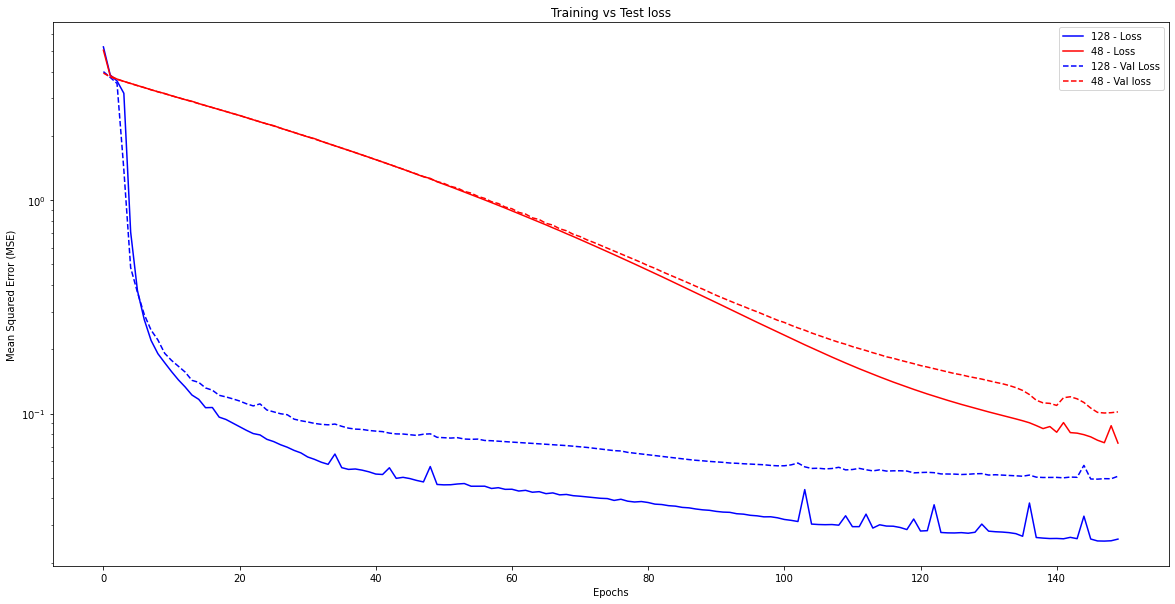

In [2]:
loss_128 = np.array(patch_128.loss)
loss_48 = np.array(patch_48.loss)

val_loss_128 = np.array(patch_128.val_loss)
val_loss_48 = np.array(patch_48.val_loss)


epochs = range(len(loss_128))

plt.figure(figsize=(20,10))
plt.plot(epochs, loss_128, 'b', label = "128 - Loss")
plt.plot(epochs, loss_48, 'r', label = "48 - Loss")
plt.plot(epochs, val_loss_128, '--b', label = "128 - Val Loss")
plt.plot(epochs, val_loss_48, '--r',label = "48 - Val loss")

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training vs Test loss')
plt.legend()




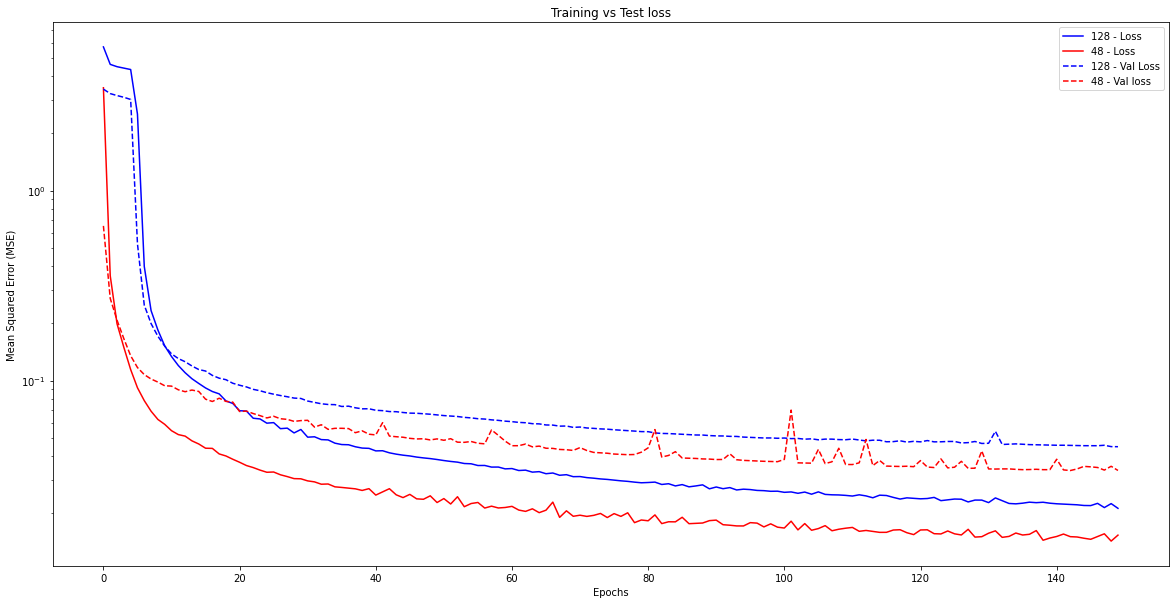

In [3]:
patch_128 = pd.read_csv(
    '../results/models_patch_try_1/model_history_log.csv') #3k data

patch_48 = pd.read_csv(
    '../results/models_patch_try/model_history_log.csv') #9k data

loss_128 = np.array(patch_128.loss)
loss_48 = np.array(patch_48.loss)

val_loss_128 = np.array(patch_128.val_loss)
val_loss_48 = np.array(patch_48.val_loss)


epochs = range(len(loss_128))
epochs = range(len(loss_128))

plt.figure(figsize=(20,10))
plt.plot(epochs, loss_128, 'b', label = "128 - Loss")
plt.plot(epochs, loss_48, 'r', label = "48 - Loss")
plt.plot(epochs, val_loss_128, '--b', label = "128 - Val Loss")
plt.plot(epochs, val_loss_48, '--r',label = "48 - Val loss")

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training vs Test loss')
plt.legend()

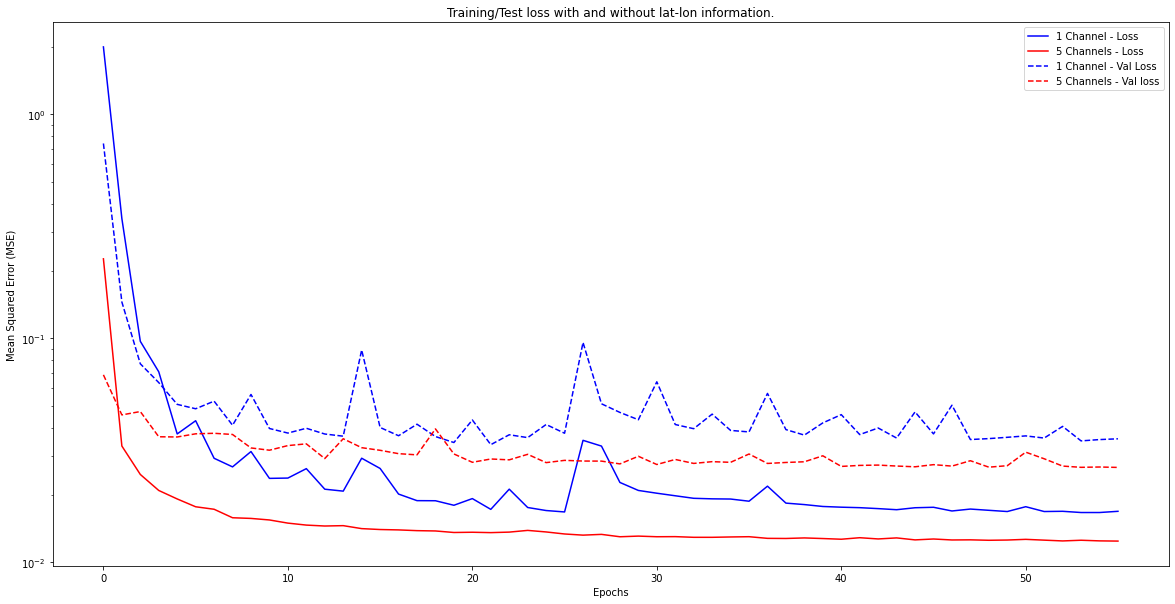

In [14]:
patch_128 = pd.read_csv(
    '../results/models_70_epochs_try_1/model_history_log.csv') #3k data

patch_48 = pd.read_csv(
    '../results/models_70_epochs_try/model_history_log.csv') #9k data

loss_128 = np.array(patch_128.loss)
loss_48 = np.array(patch_48.loss)

val_loss_128 = np.array(patch_128.val_loss)
val_loss_48 = np.array(patch_48.val_loss)

epochs = range(len(loss_48))
epochs = range(len(loss_48))

plt.figure(figsize=(20,10))
plt.plot(epochs, loss_128[0:56], 'b', label = "1 Channel - Loss")
plt.plot(epochs, loss_48, 'r', label = "5 Channels - Loss")
plt.plot(epochs, val_loss_128[0:56], '--b', label = "1 Channel - Val Loss")
plt.plot(epochs, val_loss_48, '--r',label = "5 Channels - Val loss")

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training/Test loss with and without lat-lon information.')
plt.legend()

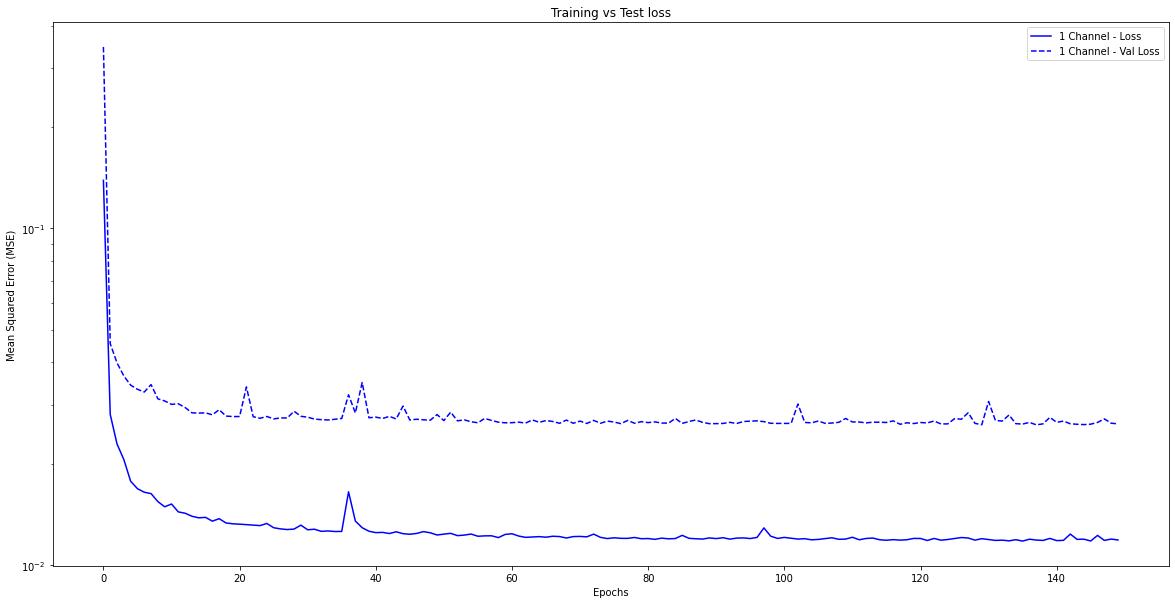

In [5]:
patch_128 = pd.read_csv(
    '../results/model_channel_400k_1/model_history_log.csv') #3k data

patch_48 = pd.read_csv(
    '../results//model_channel_400k/model_history_log.csv') #9k data

loss_128 = np.array(patch_128.loss)
loss_48 = np.array(patch_48.loss)

val_loss_128 = np.array(patch_128.val_loss)
val_loss_48 = np.array(patch_48.val_loss)


epochs = range(len(loss_128))
#epochs = range(len(loss_48))

#print(epochs)

plt.figure(figsize=(20,10))
plt.plot(epochs, loss_128, 'b', label = "1 Channel - Loss")
#plt.plot(epochs, loss_48, 'r', label = "5 Channels - Loss")
plt.plot(epochs, val_loss_128, '--b', label = "1 Channel - Val Loss")
#plt.plot(epochs, val_loss_48, '--r',label = "5 Channel - Val loss")

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training vs Test loss')
plt.legend()

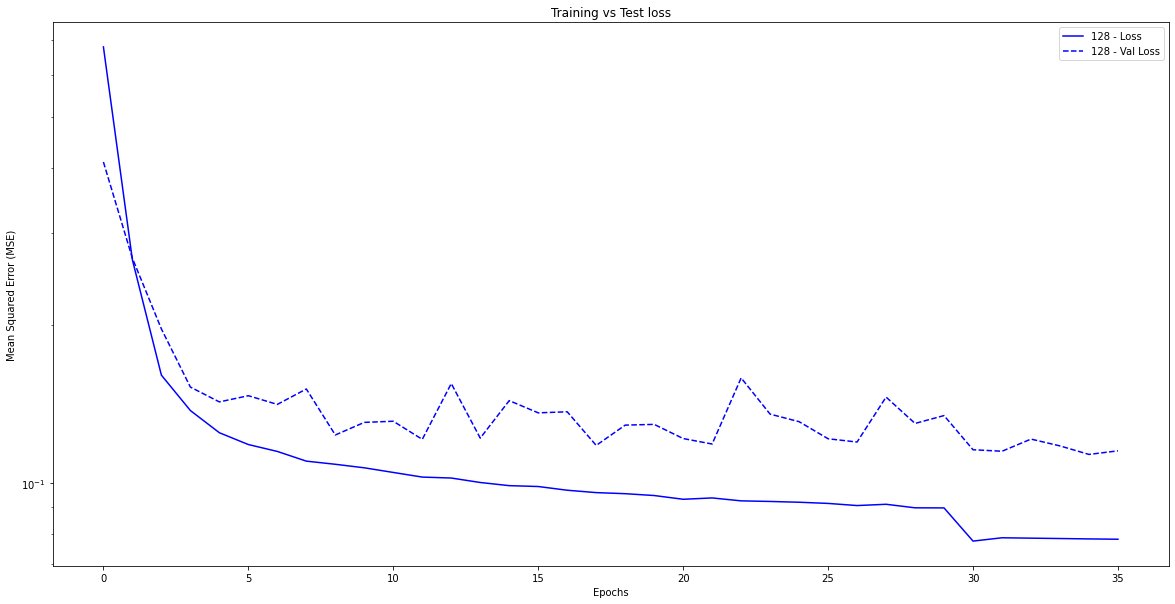

In [6]:
results_lr = pd.read_csv(
    '../results/model_channel5/model_history_log.csv')

lr_loss = np.array(results_lr.calculate_MAE_5)

val_lr_loss = np.array(results_lr.val_calculate_MAE_5)


epochs = range(len(lr_loss))

plt.figure(figsize=(20,10))
plt.plot(epochs, lr_loss, 'b', label = "128 - Loss")
plt.plot(epochs, val_lr_loss, '--b', label = "128 - Val Loss")


plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training vs Test loss')
plt.legend()



In [1]:
import pickle
import numpy as np
with open('../lossycomp/cf_1_vs_5_vs_sz_history.pkl', 'rb') as f:
    data = pickle.load(f)

In [2]:
data.keys()
data['sz'].keys()

dict_keys(['cf_0.001', 'cf_0.01', 'cf_0.1', 'cf_0.3', 'cf_0.5', 'cf_0.7', 'cf_1', 'cf_3', 'cf_5'])

In [66]:
cf_1 = []
cf_5 = []
cf_sz = []

cf_1_std = []
cf_5_std = []
cf_sz_std = []

latent_1= []
latent_5=[]
latent_sz=[]

latent_1_std= []
latent_5_std=[]
latent_sz_std=[]

error_1=[]
error_5=[]
error_sz=[]

error_1_std=[]
error_5_std=[]
error_sz_std=[]

vals =  [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1,  3, 5]


for i in [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 3, 5]:
    cf_1.append(np.mean(data['channel_1']['cf_' + str(i)]))
    cf_5.append(np.mean(data['channel_5']['cf_' + str(i)]))
    cf_sz.append(np.mean(data['sz']['cf_' + str(i)]))
    
    cf_1_std.append(np.std(data['channel_1']['cf_' + str(i)]))
    cf_5_std.append(np.std(data['channel_5']['cf_' + str(i)]))
    cf_sz_std.append(np.std(data['sz']['cf_' + str(i)]))
        
    latent_1.append(np.mean(data['channel_1']['latent_' + str(i)]))
    latent_5.append(np.mean(data['channel_5']['latent_' + str(i)]))
    latent_sz.append(np.mean(data['sz']['latent_' + str(i)]))
    
    latent_1_std.append(np.std(data['channel_1']['latent_' + str(i)]))
    latent_5_std.append(np.std(data['channel_5']['latent_' + str(i)]))
    latent_sz_std.append(np.std(data['sz']['latent_' + str(i)]))
    
    error_1.append(np.mean(data['channel_1']['error_' + str(i)]))
    error_5.append(np.mean(data['channel_5']['error_' + str(i)]))
    error_sz.append(np.mean(data['sz']['error_' + str(i)]))
    
    error_1_std.append(np.std(data['channel_1']['error_' + str(i)]))
    error_5_std.append(np.std(data['channel_5']['error_' + str(i)]))
    error_sz_std.append(np.std(data['sz']['error_' + str(i)]))

In [4]:
np.mean(data['channel_1']['cf_0.5'])

27.762772954799424

In [6]:
np.mean(data['channel_5']['cf_0.5'])

29.117492654192997

In [7]:
np.mean(data['sz']['cf_0.5'])

17.522054268644755

In [9]:
np.std(data['channel_1']['cf_0.5'])

0.44492240639717784

In [10]:
np.std(data['channel_5']['cf_0.5'])

0.6043325481627735

In [8]:
np.std(data['sz']['cf_0.5'])

0.2588653995426068

Text(0, 0.5, 'Compression Factor')

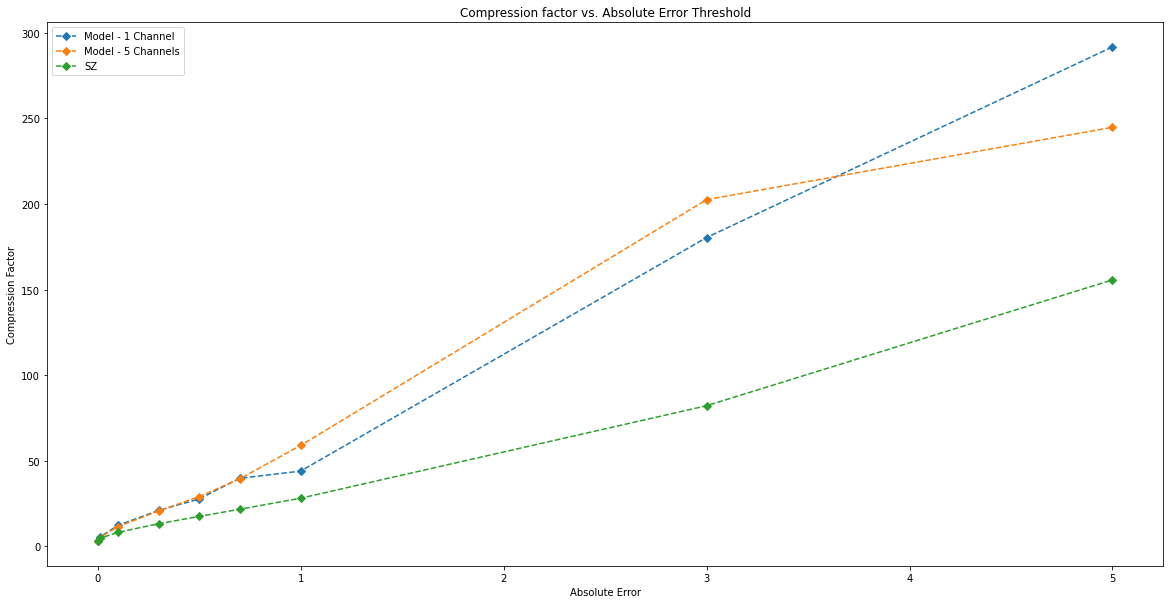

In [67]:
import matplotlib.pyplot as plt
epochs = range(len(cf_1))

plt.figure(figsize=(20,10))
plt.plot(vals, cf_1, '--D', label = "Model - 1 Channel")
plt.plot(vals, cf_5, '--D', label = "Model - 5 Channels")
plt.plot(vals, cf_sz, '--D',  label = "SZ")

plt.legend()
plt.title('Compression factor vs. Absolute Error Threshold')
plt.xlabel('Absolute Error')
plt.ylabel('Compression Factor')

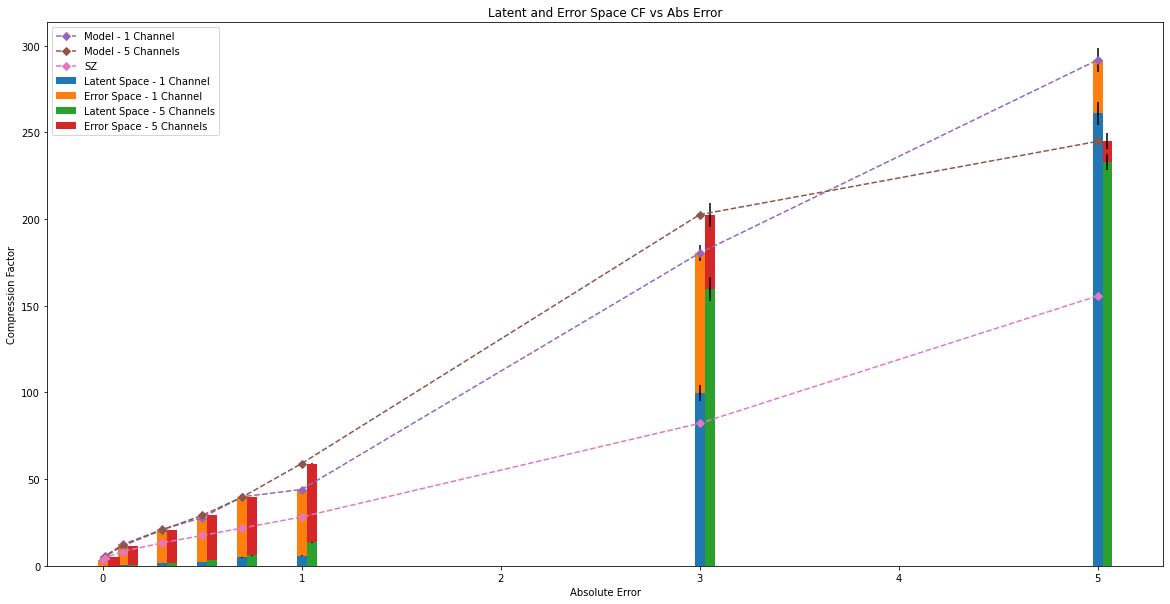

In [73]:

#plt.figure(figsize=(20,10))
width = 0.05# the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(20,10))

vals_2 = np.array(vals) + 0.05

latent_1_x = np.array(latent_1) * np.array(cf_1)
latent_5_x = np.array(latent_5) * np.array(cf_5)

error_1_x = np.array(error_1) * np.array(cf_1)
error_5_x = np.array(error_5) * np.array(cf_5)

latent_1_std_x = np.array(latent_1_std) * np.array(cf_1)
latent_5_std_x = np.array(latent_5_std) * np.array(cf_5)

error_1_std_x = np.array(error_1_std) * np.array(cf_1)
error_5_std_x = np.array(error_5_std) * np.array(cf_5)

ax.bar(vals,latent_1_x, width, yerr=latent_1_std_x, label='Latent Space - 1 Channel')
ax.bar(vals, error_1_x, width, yerr= error_1_std_x, bottom=latent_1_x,
       label='Error Space - 1 Channel')

ax.bar(vals_2,latent_5_x, width, yerr=latent_5_std_x, label='Latent Space - 5 Channels')
ax.bar(vals_2, error_5_x, width, yerr= error_5_std_x, bottom=latent_5_x,
       label='Error Space - 5 Channels')

ax.plot(vals, cf_1, '--D', label = "Model - 1 Channel")
ax.plot(vals, cf_5, '--D', label = "Model - 5 Channels")
ax.plot(vals, cf_sz, '--D',  label = "SZ")

ax.set_ylabel('Compression Factor')
ax.set_xlabel('Absolute Error')
ax.set_title('Latent and Error Space CF vs Abs Error')
ax.legend()

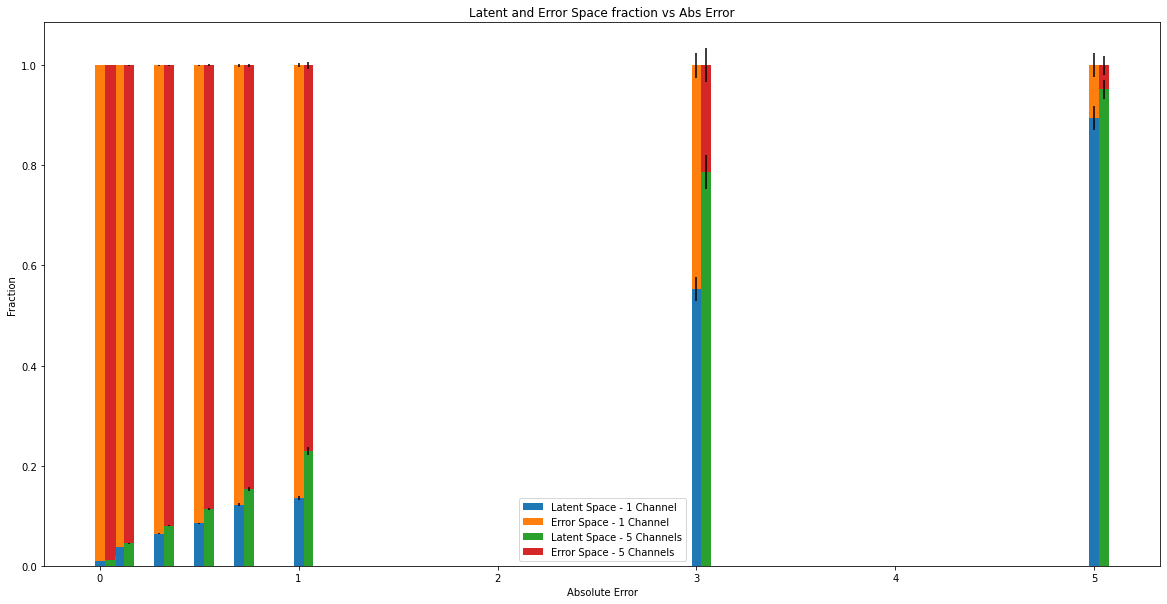

In [71]:

#plt.figure(figsize=(20,10))
width = 0.05# the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(20,10))

vals_2 = np.array(vals) + 0.05

ax.bar(vals,latent_1, width, yerr=latent_1_std, label='Latent Space - 1 Channel')
ax.bar(vals, error_1, width, yerr= error_1_std, bottom=latent_1,
       label='Error Space - 1 Channel')

ax.bar(vals_2,latent_5, width, yerr=latent_5_std, label='Latent Space - 5 Channels')
ax.bar(vals_2, error_5, width, yerr= error_5_std, bottom=latent_5,
       label='Error Space - 5 Channels')

ax.set_ylabel('Fraction')
ax.set_xlabel('Absolute Error')
ax.set_title('Latent and Error Space fraction vs Abs Error')
ax.legend()

# with gaussian kernel

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
ch_5 = pd.read_csv(
    '../results/model_5_gauss_lr_try2/model_history_log.csv') #3k data

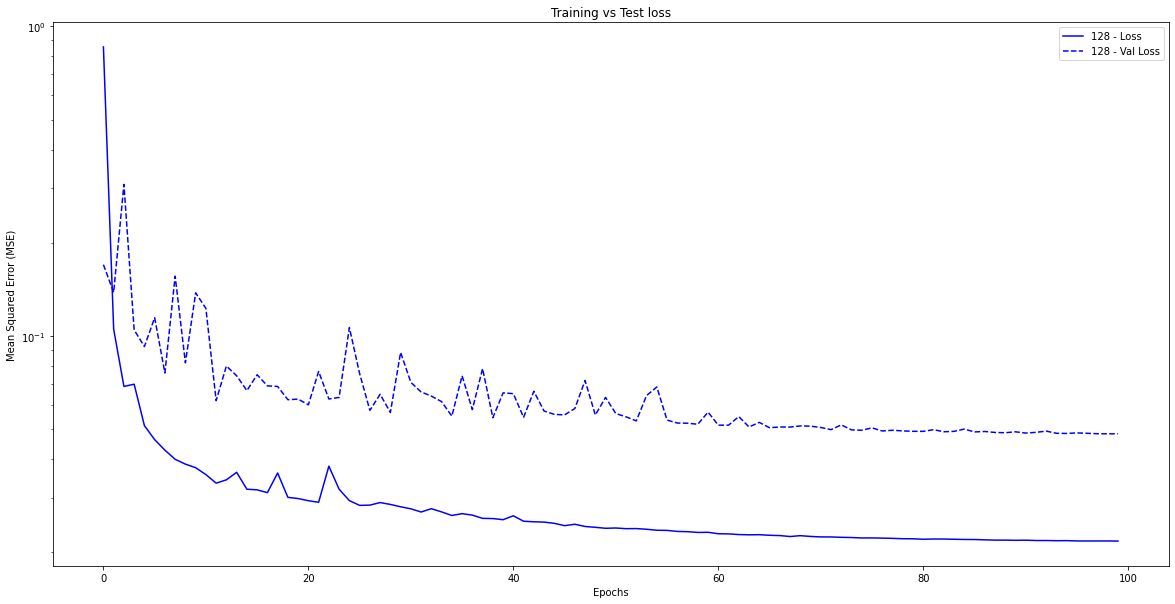

In [8]:
lr_loss = np.array(ch_5.loss)
val_lr_loss = np.array(ch_5.val_loss)


epochs = range(len(lr_loss))

plt.figure(figsize=(20,10))
plt.plot(epochs, lr_loss, 'b', label = "128 - Loss")
plt.plot(epochs, val_lr_loss, '--b', label = "128 - Val Loss")


plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training vs Test loss')
plt.legend()

In [1]:
import pickle
import numpy as np
with open('../results/FINAL/CF_conv_3_4_5.pkl', 'rb') as f:
    data = pickle.load(f)

In [2]:
cf_3 = [] 
cf_4 = []
cf_5 = []

for i in data['conv_3'].keys():
    cf_3.append(np.mean(data['conv_3'][i]))
    cf_4.append(np.mean(data['conv_4'][i]))
    cf_5.append(np.mean(data['conv_5'][i]))

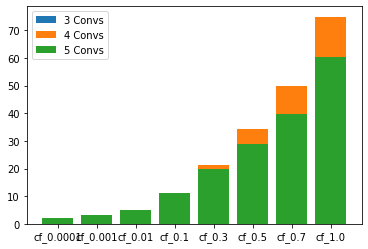

In [3]:
import matplotlib.pyplot as plt

cf = data['conv_3'].keys()
plt.bar(cf, cf_3, label = '3 Convs')
plt.bar(cf, cf_4, label = '4 Convs')
plt.bar(cf, cf_5, label = '5 Convs')
plt.legend()

/opt/bwhpc/common/devel/jupyter_ml/lib64/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, 'Compression Factor vs Abs. Error')

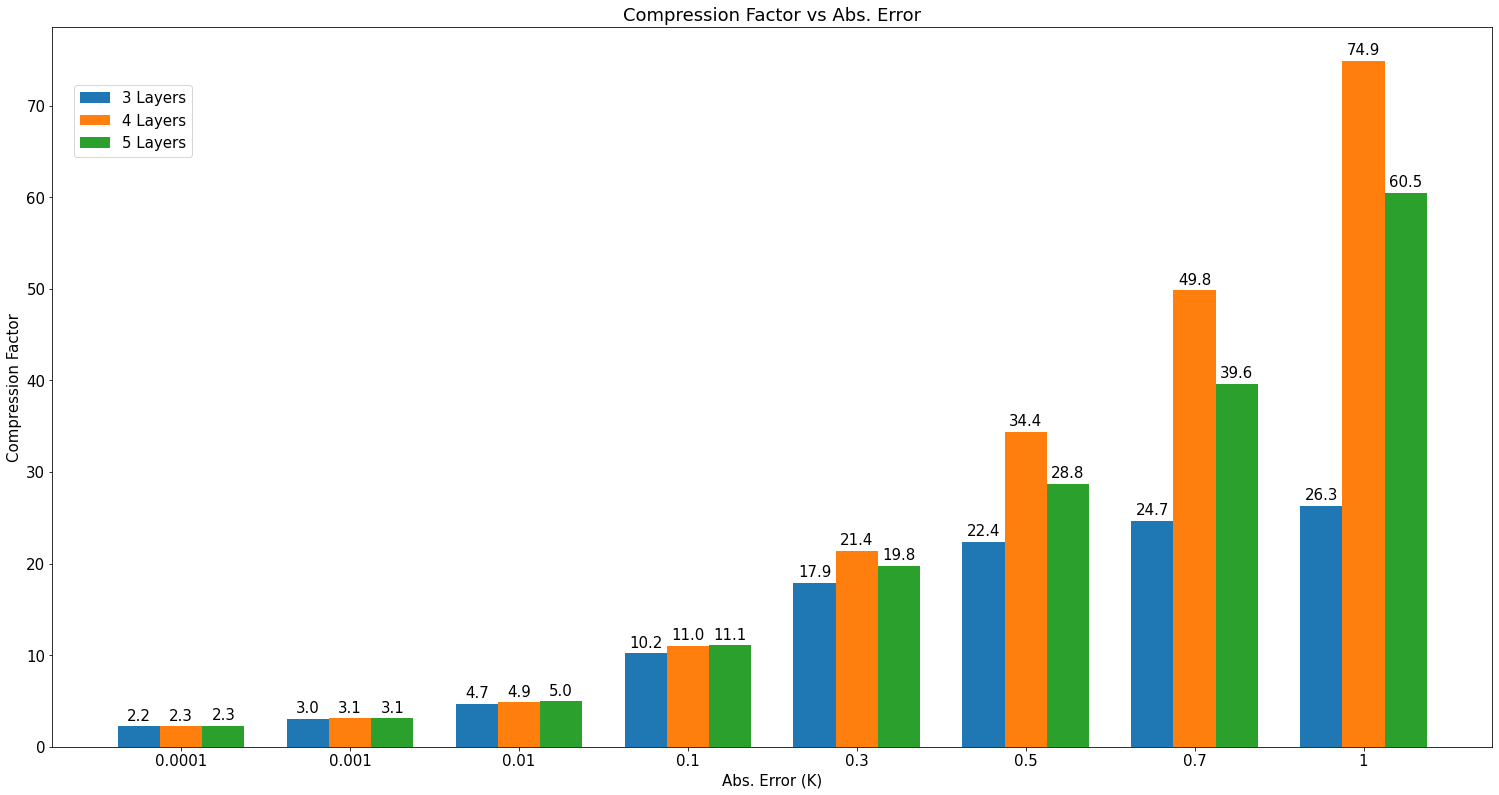

In [4]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(20,10))
cf = np.arange(8)
ax = fig.add_axes([0,0,1,1])
pps = ax.bar(cf - 0.25, cf_3, width = 0.25, label = '3 Layers')
pps1= ax.bar(cf + 0.00, cf_4, width = 0.25, label = '4 Layers')
pps2 = ax.bar(cf + 0.25, cf_5, width = 0.25, label = '5 Layers')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1:8] = ['0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1']
width = 0.25

for p in pps:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
    
    
for p in pps1:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom') 
    
for p in pps2:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
ax.set_xticklabels(labels)
fig.legend(bbox_to_anchor=(0.01, 1.03, 1, -0.1), loc=2,
           ncol=1)

plt.xlabel('Abs. Error (K)')
plt.ylabel('Compression Factor')
plt.title('Compression Factor vs Abs. Error')

In [5]:
import pickle
import numpy as np
with open('../results/FINAL/CF_conv_modes.pkl', 'rb') as f:
    data = pickle.load(f)

In [6]:
cf_basic = [] 
cf_extra = []
cf_soil = []
cf_gauss = []

for i in data['conv_extra'].keys():
    cf_basic.append(np.mean(data['conv_basic'][i]))
    cf_extra.append(np.mean(data['conv_extra'][i]))
    cf_soil.append(np.mean(data['conv_soil'][i]))
    cf_gauss.append(np.mean(data['conv_gauss'][i]))

/opt/bwhpc/common/devel/jupyter_ml/lib64/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, 'Compression Factor vs Abs. Error')

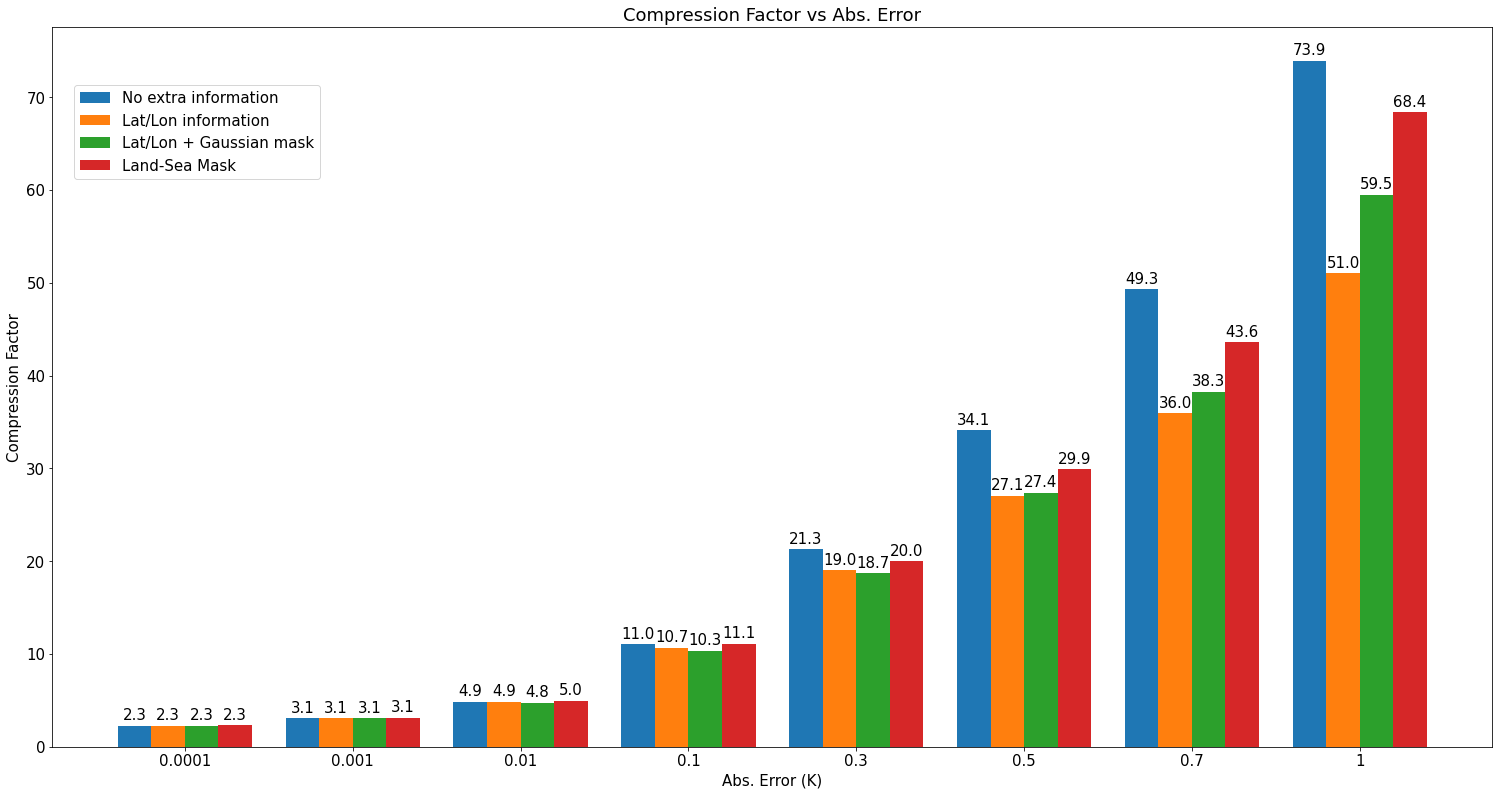

In [27]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(20,10))
cf = np.arange(8)
ax = fig.add_axes([0,0,1,1])
pps = ax.bar(cf - 0.30, cf_basic, width = 0.20, label = 'No extra information')
pps1= ax.bar(cf - 0.10, cf_extra, width = 0.20, label = 'Lat/Lon information')
pps2 = ax.bar(cf + 0.10, cf_gauss, width = 0.20, label = 'Lat/Lon + Gaussian mask')
pps3 = ax.bar(cf + 0.30, cf_soil, width = 0.20, label = 'Land-Sea Mask')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1:8] = ['0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1']
width = 0.20

for p in pps:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
    
    
for p in pps1:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom') 
    
for p in pps2:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
    
        
for p in pps3:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
    
    
ax.set_xticklabels(labels)
fig.legend(bbox_to_anchor=(0.01, 1.03, 1, -0.1), loc=2,
           ncol=1)

plt.xlabel('Abs. Error (K)')
plt.ylabel('Compression Factor')
plt.title('Compression Factor vs Abs. Error')

In [8]:
import pickle
import numpy as np
with open('../results/FINAL/trial_soil/model-history.pkl', 'rb') as f:
    data = pickle.load(f)

In [9]:
data['time']

'21:19:06.01'

In [49]:
import pickle
import numpy as np
with open('../results/FINAL/CF_sz_zfp_model_right.pkl', 'rb') as f:
    data = pickle.load(f)

In [50]:
cf_3 = [] 
cf_4 = []
cf_5 = []

for i in ['0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1.0']:
    cf_3.append(np.mean(data['model']['cf_' + str(i)]))
    cf_4.append(np.mean(data['sz']['cf_' + str(i)]))
    cf_5.append(np.mean(data['zfp']['cf_' + str(i)]))

/opt/bwhpc/common/devel/jupyter_ml/lib64/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, 'Compression Factor vs Abs. Error')

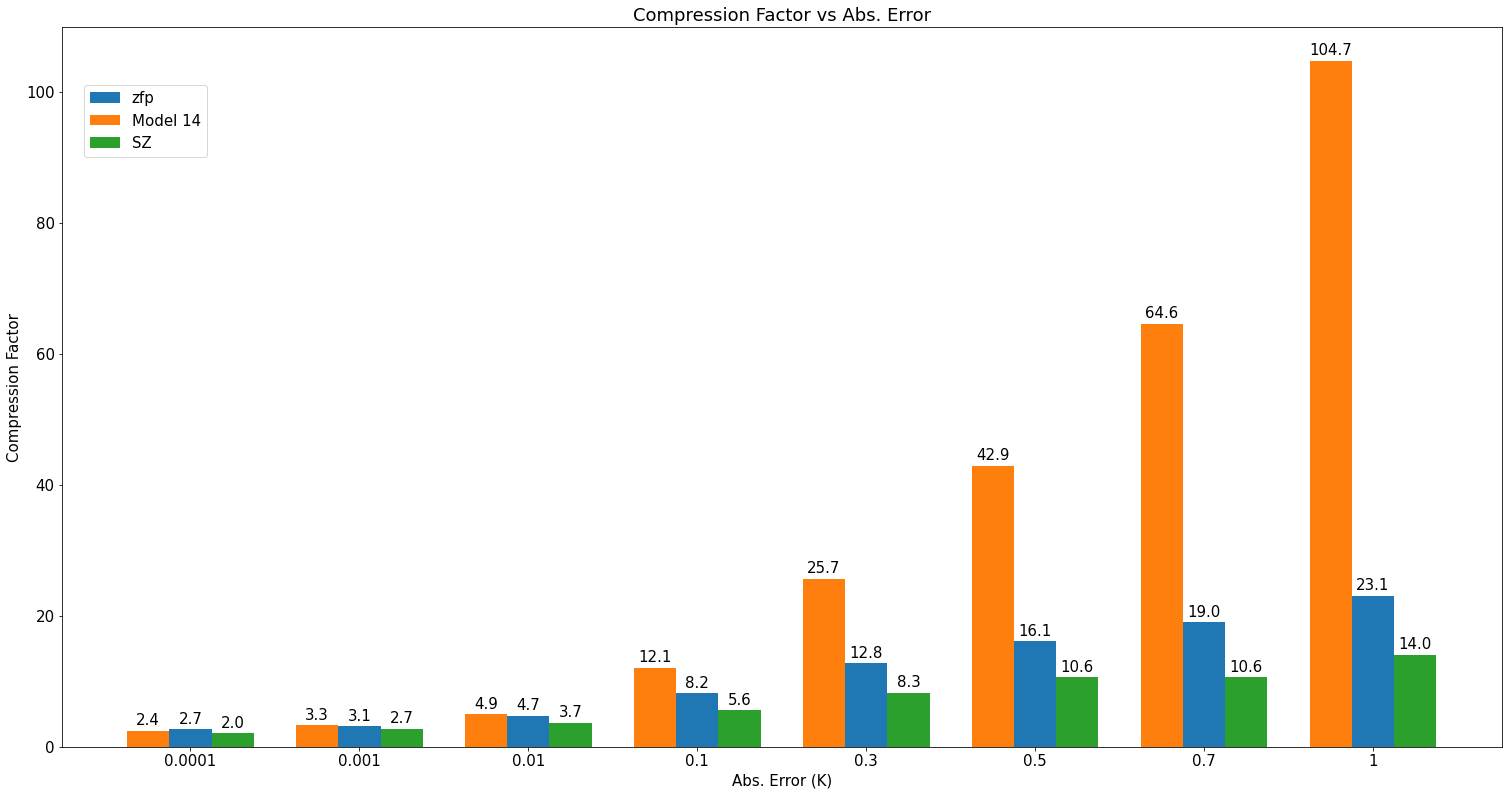

In [55]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(20,10))
cf = np.arange(8)
ax = fig.add_axes([0,0,1,1])

#pps = ax.bar(cf - 0.15, cf_basic, width = 0.30, label = 'All residuals with bzip2')
pps= ax.bar(cf + 0.00, cf_4, width = 0.25, label = 'zfp')
pps1 = ax.bar(cf - 0.25, cf_3, width = 0.25, label = 'Model 14')
pps2 = ax.bar(cf + 0.25, cf_5, width = 0.25, label = 'SZ')
labels = [item.get_text() for item in ax.get_xticklabels()]

labels = ['','0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1']
width = 0.25

for p in pps:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
    
    
for p in pps1:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom') 

for p in pps2:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

ax.set_xticklabels(labels)
fig.legend(bbox_to_anchor=(0.01, 1.03, 1, -0.1), loc=2,
           ncol=1)


plt.xlabel('Abs. Error (K)')
plt.ylabel('Compression Factor')
plt.title('Compression Factor vs Abs. Error')


In [30]:
import pickle
import numpy as np
with open('../results/FINAL/CF_hyp.pkl', 'rb') as f:
    data = pickle.load(f)

In [31]:
model_1 = []
model_2 = []
model_3 = []
model_5 = []
model_6 = []
model_7 = []
model_8 = []
model_9 = []
model_10 = []
model_11 = []
model_12 = []
model_13 = []
model_14 = []
model_15 = []
model_16 = []
model_16 = []


for j in range(8):
    model_1.append(np.mean(data['model']['model_1'][0][j]))
    model_2.append(np.mean(data['model']['model_2'][0][j]))
    model_3.append(np.mean(data['model']['model_3'][0][j]))
    model_5.append(np.mean(data['model']['model_5'][0][j]))
    model_6.append(np.mean(data['model']['model_6'][0][j]))
    model_7.append(np.mean(data['model']['model_7'][0][j]))
    model_8.append(np.mean(data['model']['model_8'][0][j]))
    model_9.append(np.mean(data['model']['model_9'][0][j]))
    model_10.append(np.mean(data['model']['model_10'][0][j]))
    model_11.append(np.mean(data['model']['model_11'][0][j]))
    model_12.append(np.mean(data['model']['model_12'][0][j]))
    model_13.append(np.mean(data['model']['model_13'][0][j]))
    model_14.append(np.mean(data['model']['model_14'][0][j]))
    model_15.append(np.mean(data['model']['model_15'][0][j]))
    model_16.append(np.mean(data['model']['model_16'][0][j]))
    model_16.append(np.mean(data['model']['model_17'][0][j]))

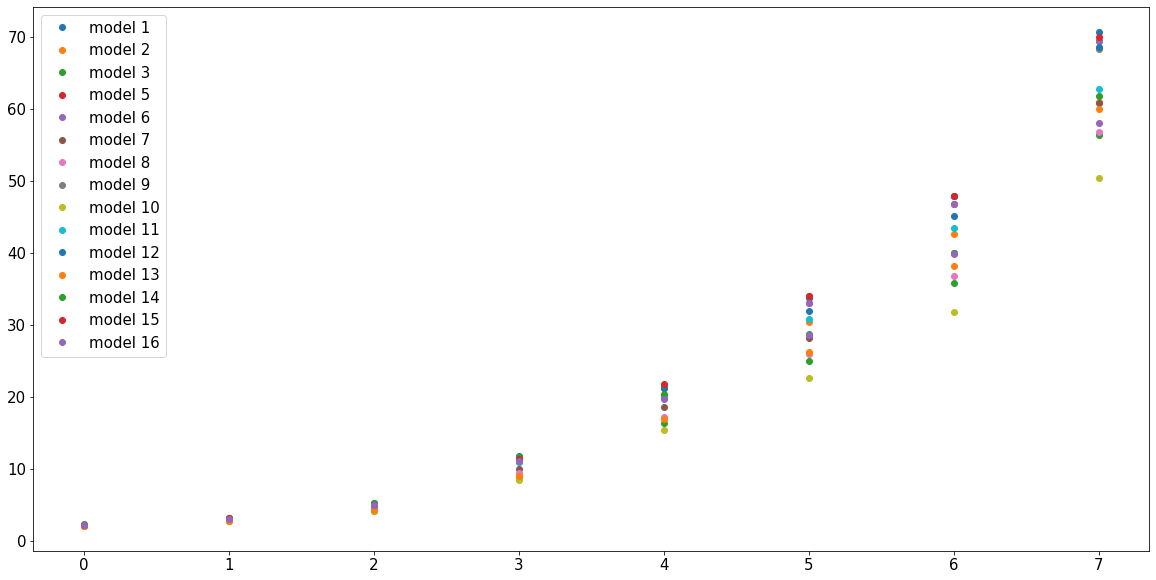

In [32]:
x = range(8)
plt.figure(figsize=(20,10))
plt.plot(x, model_1, 'o', label= 'model 1')
plt.plot(x, model_2, 'o', label= 'model 2')
plt.plot(x, model_3, 'o' ,label= 'model 3')
plt.plot(x, model_5, 'o', label= 'model 5')
plt.plot(x, model_6, 'o', label= 'model 6')
plt.plot(x, model_7, 'o', label= 'model 7')
plt.plot(x, model_8, 'o', label= 'model 8')
plt.plot(x, model_9,  'o', label= 'model 9')
plt.plot(x, model_10, 'o', label= 'model 10')
plt.plot(x, model_11, 'o', label= 'model 11')
plt.plot(x, model_12, 'o', label= 'model 12')
plt.plot(x, model_13, 'o', label= 'model 13')
plt.plot(x, model_14, 'o', label= 'model 14')
plt.plot(x, model_15, 'o', label= 'model 15')
plt.plot(x, model_16, 'o', label= 'model 16')
plt.legend()

In [48]:
model_17

NameError: name 'model_17' is not defined

In [10]:
import pickle
import numpy as np
with open('../../results/test/model-history.pkl', 'rb') as f:
    data = pickle.load(f)

In [11]:
data

{'parameters': {'name': 'test',
  'num_convs': 4,
  'num_filters': 20,
  'kernel_size': 5,
  'lr': 0.0007455023032335825,
  'res_blocks': 0,
  'l2': 0.0003035740632363896,
  'extra': False,
  'gaussian': False},
 'model': defaultdict(list,
             {'loss': [0.7352696061134338,
               0.09415551275014877,
               0.07176246494054794,
               0.06610745191574097],
              'mse': [0.7252898216247559,
               0.08380001783370972,
               0.06176961213350296,
               0.0567316934466362],
              'psnr': [8.233288764953613,
               8.295005798339844,
               8.30471420288086,
               8.3026704788208],
              'correlation_5': [0.7580527663230896,
               0.9736761450767517,
               0.9804735779762268,
               0.9823973178863525],
              'lr': [0.0007455023, 0.0007455023, 0.0007455023, 0.0007455023],
              'val_loss': [0.10247812420129776, 0.08176368474960327],
          

In [5]:
import pickle
import numpy as np
with open('../../results/FINAL_2/CF_sz_zfp_model_2.pkl', 'rb') as f:
    data = pickle.load(f)

In [7]:
cf_1 = []
cf_2 = []
cf_3 = []
cf_4 = []
cf_sz = []
cf_zfp = []

time_1 = []
time_2 = []
time_3 = []
time_4 = []
time_sz = []
time_zfp = []

latent_1 = []
latent_2 = []
latent_3 = []
latent_4 = []
latent_sz = []
latent_zfp = []

error_1 = []
error_2 = []
error_3 = []
error_4 = []
error_sz = []
error_zfp = []

mask_1 = []
mask_2 = []
mask_3 = []
mask_4 = []
mask_sz = []
mask_zfp = []


for i in ['0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1.0']:
    cf_1.append(np.mean(data['model_1']['cf_' + str(i)]))
    cf_2.append(np.mean(data['model_2']['cf_' + str(i)]))
    cf_3.append(np.mean(data['model_3']['cf_' + str(i)]))
    cf_sz.append(np.mean(data['sz']['cf_' + str(i)]))
    cf_zfp.append(np.mean(data['zfp']['cf_' + str(i)]))
    
    time_1.append(np.mean(data['model_1']['time_' + str(i)]))
    time_2.append(np.mean(data['model_2']['time_' + str(i)]))
    time_3.append(np.mean(data['model_3']['time_' + str(i)]))
    time_sz.append(np.mean(data['sz']['time_' + str(i)]))
    time_zfp.append(np.mean(data['zfp']['time_' + str(i)]))
    
    latent_1.append(np.mean(data['model_1']['latent_' + str(i)]))
    latent_2.append(np.mean(data['model_2']['latent_' + str(i)]))
    latent_3.append(np.mean(data['model_3']['latent_' + str(i)]))
    latent_sz.append(np.mean(data['sz']['latent_' + str(i)]))
    latent_zfp.append(np.mean(data['zfp']['latent_' + str(i)]))
    
    error_1.append(np.mean(data['model_1']['error_' + str(i)]))
    error_2.append(np.mean(data['model_2']['error_' + str(i)]))
    error_3.append(np.mean(data['model_3']['error_' + str(i)]))
    error_sz.append(np.mean(data['sz']['error_' + str(i)]))
    error_zfp.append(np.mean(data['zfp']['error_' + str(i)]))
    
    mask_1.append(np.mean(data['model_1']['mask_' + str(i)]))
    mask_2.append(np.mean(data['model_2']['mask_' + str(i)]))
    mask_3.append(np.mean(data['model_3']['mask_' + str(i)]))
    mask_sz.append(np.mean(data['sz']['mask_' + str(i)]))
    mask_zfp.append(np.mean(data['zfp']['mask_' + str(i)]))



<ipython-input-8-319c9d3b8d9a>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


Text(0.5, 1.0, 'Compression Factor vs Abs. Error')

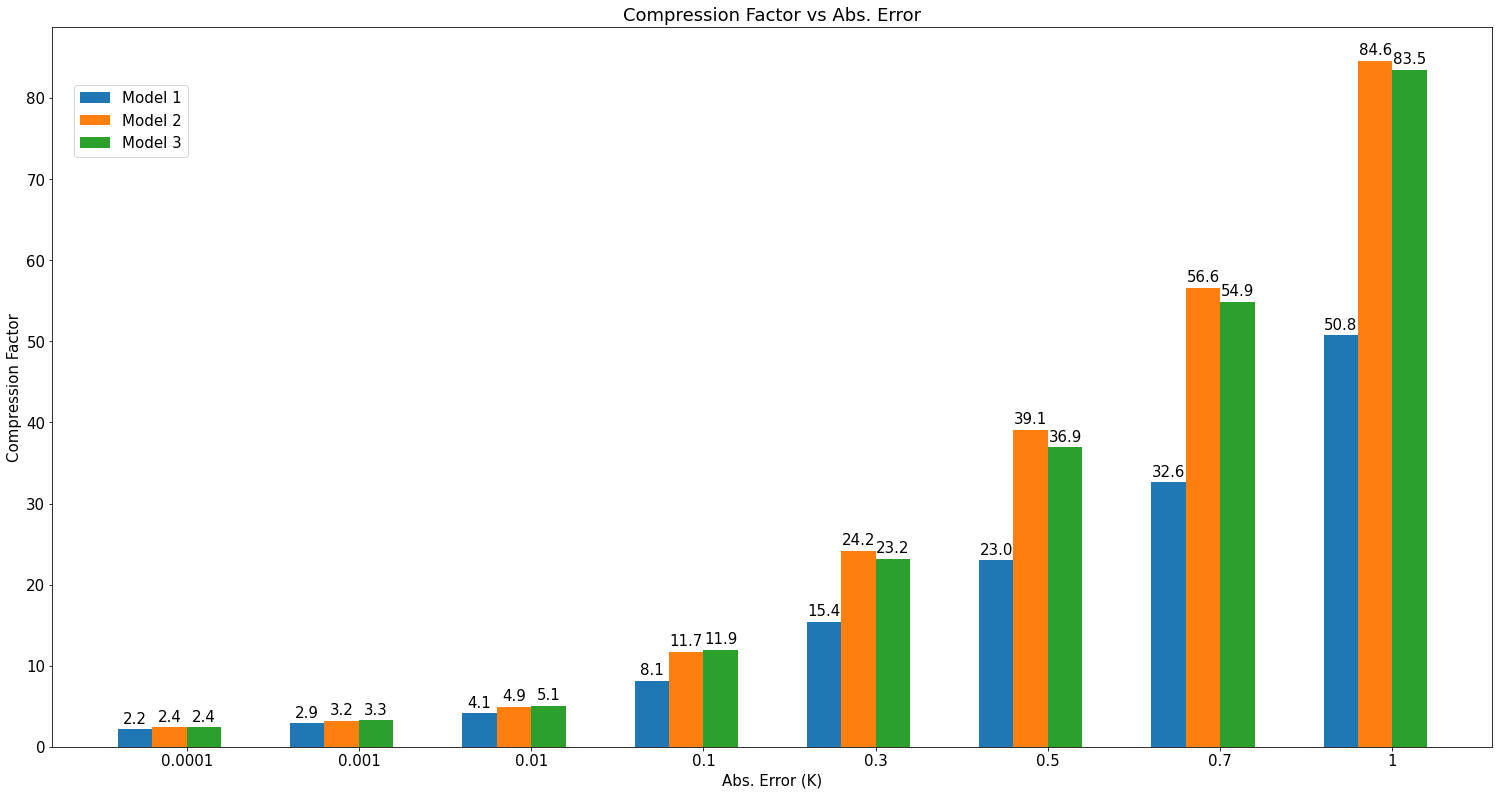

In [8]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(20,10))
cf = np.arange(8)
ax = fig.add_axes([0,0,1,1])
pps = ax.bar(cf - 0.30, cf_1, width = 0.20, label = 'Model 1')
pps1= ax.bar(cf - 0.10, cf_2, width = 0.20, label = 'Model 2')
pps2 = ax.bar(cf + 0.10, cf_3, width = 0.20, label = 'Model 3')
#pps3 = ax.bar(cf + 0.30, cf_4, width = 0.20, label = 'Land-Sea Mask')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1:8] = ['0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1']
width = 0.20

for p in pps:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
    
    
for p in pps1:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom') 
    
for p in pps2:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
    
        
#for p in pps3:
#    height = p.get_height()
#    ax.annotate('{}'.format(round(height,1)),
#      xy=(p.get_x() + p.get_width() / 2, height),
#      xytext=(0, 3), # 3 points vertical offset
#      textcoords="offset points",
#      ha='center', va='bottom')
    
    
ax.set_xticklabels(labels)
fig.legend(bbox_to_anchor=(0.01, 1.03, 1, -0.1), loc=2,
           ncol=1)

plt.xlabel('Abs. Error (K)')
plt.ylabel('Compression Factor')
plt.title('Compression Factor vs Abs. Error')

Text(0.5, 1.0, 'Model 3')

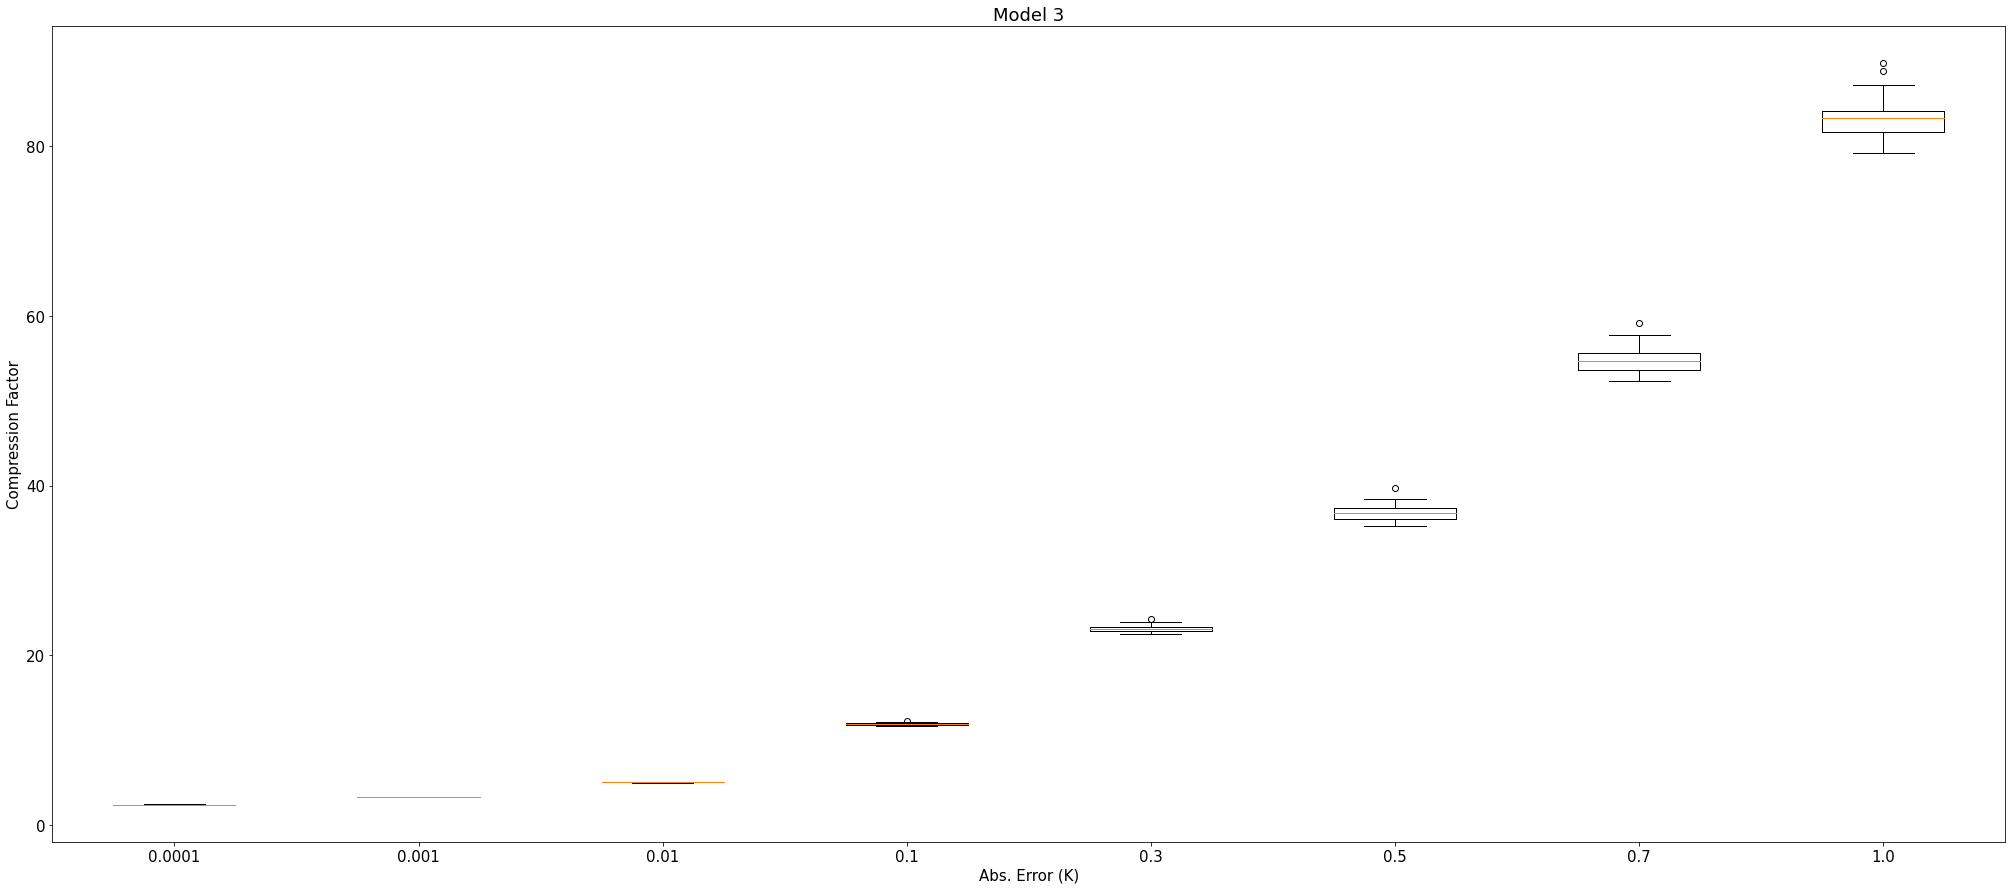

In [13]:
import numpy
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(35,15))
"""
plt.boxplot([numpy.array(data['model_1']['cf_1.0'][0]), 
             numpy.array(data['model_2']['cf_1.0'][0]),
             numpy.array(data['model_3']['cf_1.0'][0])])
"""

mod_1 = []
mod_2 = []
mod_3 = []

for i in ['0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1.0']:
    mod_1.append(numpy.array(data['model_1']['cf_' + str(i)][0]))
    mod_2.append(numpy.array(data['model_2']['cf_' + str(i)][0]))
    mod_3.append(numpy.array(data['model_3']['cf_' + str(i)][0]))


    
#figure, axes = plt.subplots(nrows=3, figsize=(20,15))


#axes[0].boxplot(mod_1) 
#axes[1].boxplot(mod_2) 
plt.boxplot(mod_3)

plt.xticks([1, 2, 3,4,5,6,7,8],['0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1.0'])
plt.ylabel('Compression Factor')
plt.xlabel('Abs. Error (K)')
plt.title('Model 3')


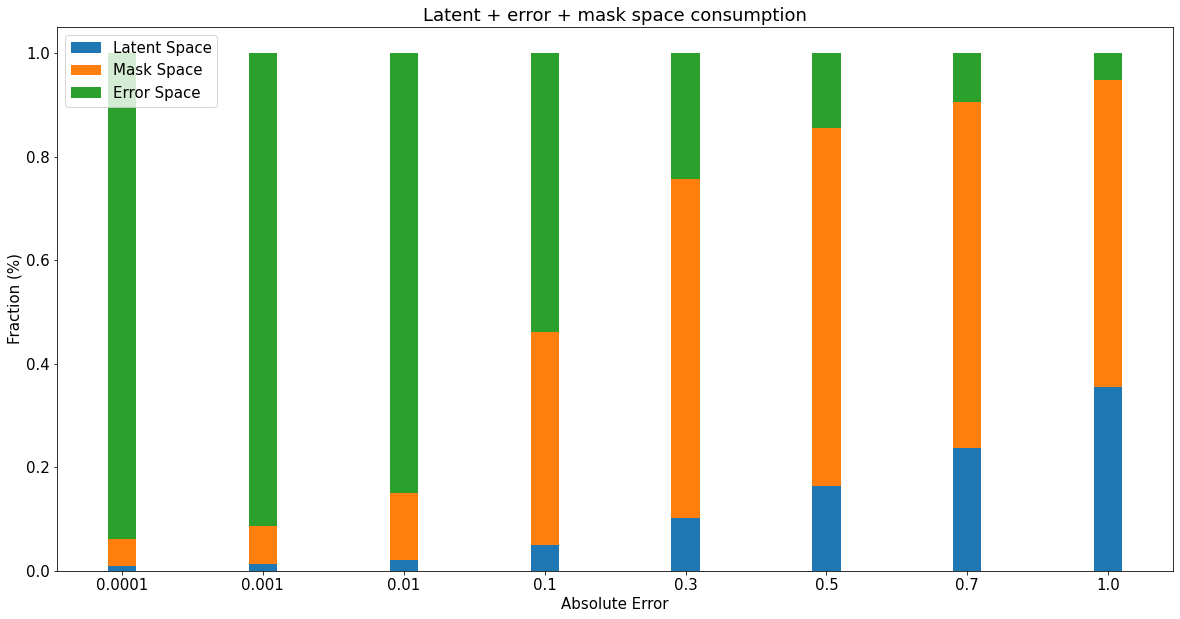

In [27]:
#plt.figure(figsize=(20,10))
import numpy as np
width = 0.20# the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(20,10))


ax.bar( ['0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1.0'], latent_2, width,  label='Latent Space')
ax.bar( ['0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1.0'], error_2, width,  bottom = latent_2,
       label='Mask Space')
ax.bar( ['0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1.0'], mask_2, width,  label='Error Space', bottom =np.array(latent_2)+np.array(error_2))


ax.set_ylabel('Fraction (%)')
ax.set_xlabel('Absolute Error')
ax.set_title('Latent + error + mask space consumption')
ax.legend()

<ipython-input-33-4e58067129d4>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


Text(0.5, 1.0, 'Execution time(s) vs Abs. Error')

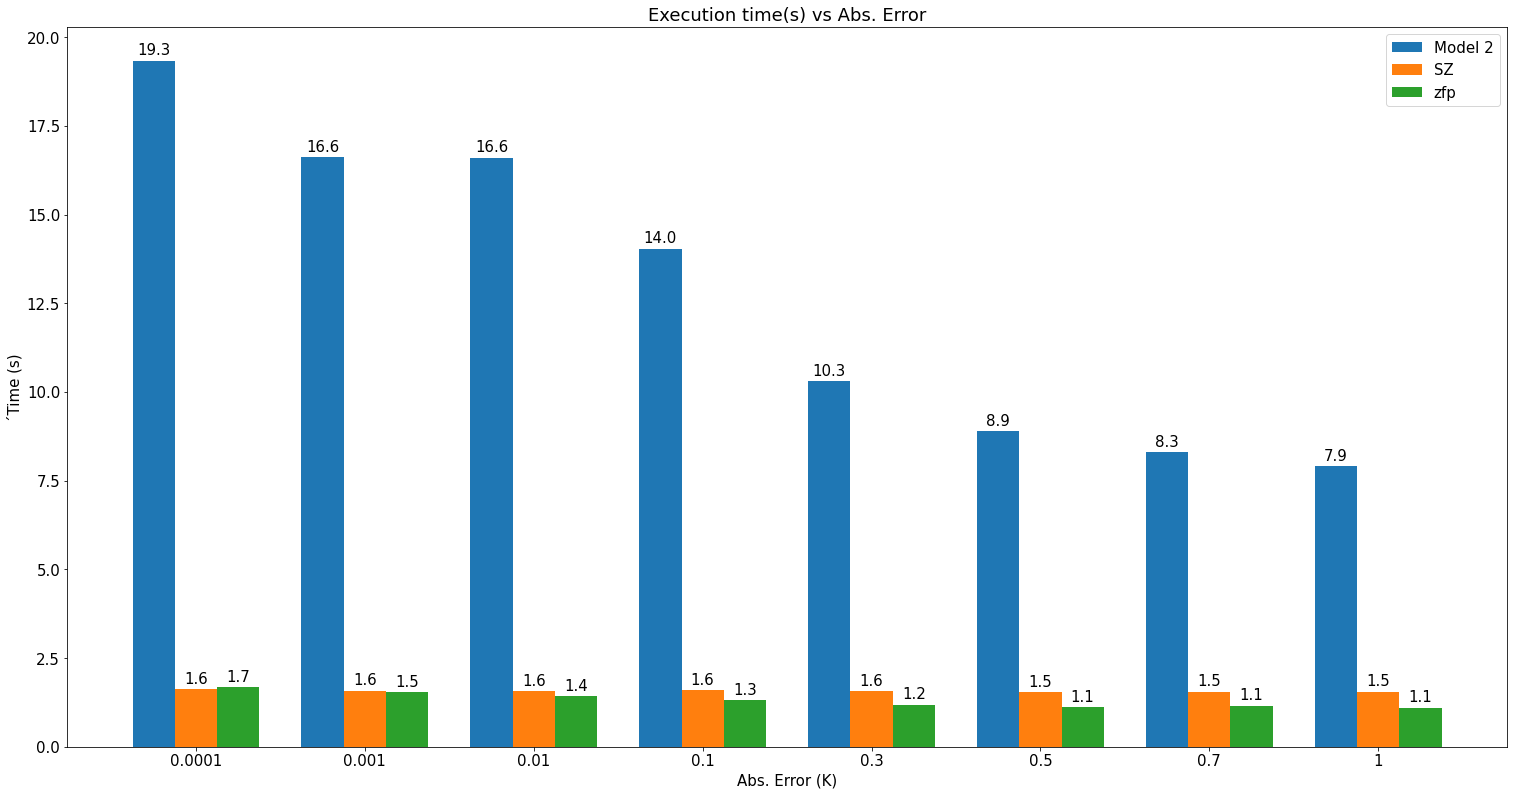

In [33]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(20,10))
cf = np.arange(8)
ax = fig.add_axes([0,0,1,1])

#pps = ax.bar(cf - 0.15, cf_basic, width = 0.30, label = 'All residuals with bzip2')
pps= ax.bar(cf - 0.25, time_2, width = 0.25, label = 'Model 2')
pps1 = ax.bar(cf - 0.00, time_sz, width = 0.25, label = 'SZ')
pps2 = ax.bar(cf + 0.25, time_zfp, width = 0.25, label = 'zfp')
labels = [item.get_text() for item in ax.get_xticklabels()]

labels = ['','0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1']
width = 0.25

for p in pps:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')
    
    
for p in pps1:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom') 

for p in pps2:
    height = p.get_height()
    ax.annotate('{}'.format(round(height,1)),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

ax.set_xticklabels(labels)
#fig.legend(bbox_to_anchor=(0.01, 1.03, 1, -0.1), loc=2,
#           ncol=1)
plt.legend()

plt.xlabel('Abs. Error (K)')
plt.ylabel('´Time (s)')
plt.title('Execution time(s) vs Abs. Error')